## 使用 DeepAR 进行股价预测

像之前一样，我们将使用白酒行业的股票，将这些系列的收盘价作为将要预测的时间序列建立模型。但是，这里的区别在于，我们不必指定哪个是主序列，哪些是外生序列。DeepAR 算法致力于建立一个统一的模型，该模型将考虑所有提供的时间序列中的趋势，并可以针对任何这些趋势生成预测。这将避免需要针对不同的时间序列构建不同的模型。

正如在自定义 RNN 示例中使用协变量时间序列一样，我们可以通过使用 Dynamic Feature 在 DeepAR 上起到类似的效果。DeepAR 还可以通过整数定义不同股票的类型。在股价预测的场景中，您可以将不同行业的股票都一同进行训练。假设这些行业板块之间确实存在某种可靠的正相关/负相关的关联性，DeepAR 就可以学习和捕捉这些关系，这往往可以提升模型的准确性。

开始之前，清选择 conda_python3 内核。

### 定义参数

在之前的自定义 RNN 示例中，我们实现了训练代码，因此可以使用超参数来自定义训练的某些方面。对于DeepAR，就像任何AWS提供的算法一样，您可以使用类似的hyparparameters配置来充分利用模型。

DeepAR 允许您控制神经网络体系结构，例如网络的层数、每层中的循环单元数层、学习率，预测长度等。需要注意的是，更高的预测长度会消耗相当多的内存资源，因此建议您适当对超参进行选择。在以下的示例中，我们配置了一些超参，以便在合理的时间内完成训练。你可能注意到有些超参和之前的自定义 RNN 模型超参略有不同。

In [2]:
import boto3

aws_account_id = boto3.client('sts').get_caller_identity().get('Account')
my_name = 'peng'
aws_region = 'us-east-1'
bucket = 'algo-trading-workshop-{}'.format(my_name)
repository_name = 'sagemaker-deepar'

In [3]:
target_stock = "600519" #  贵州茅台
covariate_stocks = "000596,000568,000858,600779,002304" # 古井贡酒、泸州老窖、五粮液、水井坊、洋河股份
target_column = "close" # 需要预测的目标值
covariate_columns = "open,low,high"
covariates = covariate_stocks.split(',')
covariate_columns = covariate_columns.split(',')

interval = 'D' # 基于日线进行预测
prediction_length = 91  
context_length = 91
train_test_split = 0.8
num_test_windows = 4

hyperparameters = {
    "prediction_length": str(prediction_length), # number of time-steps model is trained to predict, always generates forecasts with this length
    "context_length": str(context_length), # number of time-points that the model gets to see before making the prediction, should be about same as the prediction_length
    "time_freq": interval, # granularity of the time series in the dataset
    "epochs": "200", # maximum number of passes over the training data
    "early_stopping_patience": "40", #training stops when no progress is made within the specified number of epochs
    "num_layers": "2", #number of hidden layers in the RNN, typically range from 1 to 4    
    "num_cells": "40", #number of cells to use in each hidden layer of the RNN, typically range from 30 to 100
    "mini_batch_size": "128", #size of mini-batches used during training, typically values range from 32 to 512
    "learning_rate": "1e-3", #learning rate used in training. Typical values range from 1e-4 to 1e-1
    "dropout_rate": "0.1", # dropout rate to use for regularization, typically less than 0.2. 
    "likelihood": "gaussian" # noise model used for uncertainty estimates - gaussian/beta/negative-binomial/student-T/deterministic-L1
}

metrics=[]
metrics.extend(covariate_columns)
metrics.append(target_column)
print('Metrics:', metrics)

Metrics: ['open', 'low', 'high', 'close']


### 获取数据

与自定义 RNN 模型类似，我们先调取 1000 个交易日的数据进行训练：

In [4]:
# !pip install awswrangler

import awswrangler as wr

s3_output = wr.athena.create_athena_bucket()

def execute_query(database, sql):
    
    query_execution_id = wr.athena.start_query_execution(database=database, sql=sql)
    response = wr.athena.get_query_execution(query_execution_id=query_execution_id)
    wr.athena.wait_query(query_execution_id=query_execution_id)
    OutputLocation = response['ResultConfiguration']['OutputLocation']
    
    return OutputLocation

In [5]:
database = 'stock-data'
table = 'stock_day'
fields = '*'
ticker = target_stock
orderby = 'tradedate'
sort = 'DESC'
limit = '1000'

sql = f'''
SELECT {fields}
FROM "{database}"."{table}"
WHERE ticker='{ticker}'
ORDER BY {orderby}
{sort}
LIMIT {limit}
'''

output_location = execute_query(database, sql)

In [6]:
df = wr.s3.read_csv(path=[output_location])

df['ticker'] = df['ticker'].apply(lambda x: str(x))
df['ticker'] = df['ticker'].apply(lambda x: '0'*(6-len(x)) + x)
df['openprice'] = df['openprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['closeprice'] = df['closeprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['highestprice'] = df['highestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['lowestprice'] = df['lowestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df = df[df['isopen'] == True]
df.drop('isopen', 1, inplace=True)
df.drop('accumadjfactor', 1, inplace=True)
df.drop('secid', 1, inplace=True)
df.set_index('tradedate', inplace=True)
df.sort_index(0, inplace=True)

df.rename(columns={'openprice': 'open'}, inplace=True)
df.rename(columns={'closeprice': 'close'}, inplace=True)
df.rename(columns={'highestprice': 'high'}, inplace=True)
df.rename(columns={'lowestprice': 'low'}, inplace=True)
df.rename(columns={'turnovervol': 'volume'}, inplace=True)
df.rename(columns={'turnovervalue': 'value'}, inplace=True)
df.head()

,ticker,open,high,low,close,volume,value
tradedate,,,,,,,
2017-05-26,600519,450.82,455.60,448.00,451.92,2738664.0,1.237323e+09
2017-05-31,600519,450.00,450.50,440.11,442.94,4431225.0,1.968887e+09
2017-06-01,600519,442.50,449.95,441.01,449.28,4060478.0,1.808306e+09
2017-06-02,600519,450.00,450.95,445.60,447.31,2178526.0,9.748933e+08
2017-06-05,600519,448.04,449.00,442.35,444.41,1924120.0,8.548769e+08


In [7]:
start_date = df.index[0]
end_date = df.index[-1]
print('Target stock:', ticker, start_date, '-', end_date)

import pandas as pd

stock_data = pd.DataFrame([])
stock_data = pd.concat([stock_data, df])

Target stock: 600519 2017-05-26 - 2021-07-05


In [8]:
covariates = covariate_stocks.split(',')
for ticker in covariates:
    
    sql = f'''
    SELECT {fields}
    FROM "{database}"."{table}"
    WHERE ticker='{ticker}'
    AND tradedate>='{start_date}'
    ORDER BY {orderby}
    {sort}
    '''
    
    output_location = execute_query(database, sql)
    df = wr.s3.read_csv(path=[output_location])
    
    df['ticker'] = df['ticker'].apply(lambda x: str(x))
    df['ticker'] = df['ticker'].apply(lambda x: '0'*(6-len(x)) + x)
    df['openprice'] = df['openprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
    df['closeprice'] = df['closeprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
    df['highestprice'] = df['highestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
    df['lowestprice'] = df['lowestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
    df = df[df['isopen'] == True]
    df.drop('isopen', 1, inplace=True)
    df.drop('accumadjfactor', 1, inplace=True)
    df.drop('secid', 1, inplace=True)
    df.set_index('tradedate', inplace=True)
    df.sort_index(0, inplace=True)

    df.rename(columns={'openprice': 'open'}, inplace=True)
    df.rename(columns={'closeprice': 'close'}, inplace=True)
    df.rename(columns={'highestprice': 'high'}, inplace=True)
    df.rename(columns={'lowestprice': 'low'}, inplace=True)
    df.rename(columns={'turnovervol': 'volume'}, inplace=True)
    df.rename(columns={'turnovervalue': 'value'}, inplace=True)
    
    print(ticker, df.shape, df.index[0], df.index[-1])
    
    stock_data = pd.concat([stock_data, df])

000596 (999, 7) 2017-05-26 2021-07-05
000568 (999, 7) 2017-05-26 2021-07-05
000858 (1000, 7) 2017-05-26 2021-07-05
600779 (997, 7) 2017-05-26 2021-07-05
002304 (999, 7) 2017-05-26 2021-07-05


In [9]:
def normalize_data(data, target_column, covariate_columns):
    
    normalized_data = pd.DataFrame([])
    for ticker in data['ticker'].unique():
        df = data[data['ticker'] == ticker]
        df.drop(['ticker'], 1, inplace=True)

        for col in df.columns:
            if (col != target_column) and (col not in covariate_columns):
                df.drop(col, 1, inplace=True)
            else:
                df.rename(columns={col: ticker+'-'+col}, inplace=True)

        normalized_data = normalized_data.combine_first(df)

    normalized_data.fillna(method='ffill', inplace=True)
    
    return normalized_data

In [10]:
df = normalize_data(stock_data, target_column, covariate_columns)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
stock_data.head()

,ticker,open,high,low,close,volume,value
tradedate,,,,,,,
2017-05-26,600519,450.82,455.60,448.00,451.92,2738664.0,1.237323e+09
2017-05-31,600519,450.00,450.50,440.11,442.94,4431225.0,1.968887e+09
2017-06-01,600519,442.50,449.95,441.01,449.28,4060478.0,1.808306e+09
2017-06-02,600519,450.00,450.95,445.60,447.31,2178526.0,9.748933e+08
2017-06-05,600519,448.04,449.00,442.35,444.41,1924120.0,8.548769e+08


在开始训练之前，我们先把数据集按照日期进行简单拆分。这里大约 800 个交易日作为训练集，4 x 50 个交易日作为测试集。DeepAR 需要数据格式为 JSON：

In [12]:
df.head()

,000568-close,000568-high,000568-low,000568-open,000596-close,000596-high,000596-low,000596-open,000858-close,000858-high,...,002304-low,002304-open,600519-close,600519-high,600519-low,600519-open,600779-close,600779-high,600779-low,600779-open
tradedate,,,,,,,,,,,,,,,,,,,,,
2017-05-26,48.53,48.74,47.50,48.60,47.89,48.50,47.70,47.84,47.56,48.26,...,85.57,86.90,451.92,455.60,448.00,450.82,22.70,22.98,22.36,22.49
2017-05-31,48.22,48.41,46.94,48.10,47.40,48.39,46.80,47.89,47.88,47.88,...,85.30,86.92,442.94,450.50,440.11,450.00,22.79,23.08,22.45,22.59
2017-06-01,48.01,48.48,47.46,47.74,47.21,47.68,46.99,47.00,48.34,48.54,...,86.00,86.68,449.28,449.95,441.01,442.50,23.69,24.05,22.65,22.84
2017-06-02,47.46,48.24,47.10,48.02,46.97,47.57,46.29,47.21,47.96,48.74,...,85.55,87.30,447.31,450.95,445.60,450.00,23.40,24.00,23.21,23.69
2017-06-05,46.69,47.63,46.47,47.37,46.15,47.20,45.97,46.97,47.09,48.50,...,84.20,86.59,444.41,449.00,442.35,448.04,23.14,23.64,23.03,23.47


In [13]:
def json_serialize(data, start, end, target_column, covariate_columns, interval):
    
    timeseries = {}
    for i, col in enumerate(data.columns):
        metric = col[col.find('-')+1:]
        ticker = col[:col.find('-')]
        if metric == target_column:
            if ticker in timeseries.keys():
                timeseries[ticker]["target"] = data.iloc[:,i][start:end]
            else:
                timeseries[ticker] = {}
                timeseries[ticker]["start"] = str(pd.Timestamp(start, freq = interval))
                timeseries[ticker]["target"] = data.iloc[:,i][start:end]            
            print("Time series for {} added".format(ticker))
        elif metric in covariate_columns:
            if ticker in timeseries.keys():
                if "dynamic_feat" in timeseries[ticker]:
                    dynamic_feat = timeseries[ticker]["dynamic_feat"]
                    dynamic_feat.append(data.iloc[:,i][start:end])
                else:
                    dynamic_feat = []
                    dynamic_feat.append(data.iloc[:,i][start:end])
                    timeseries[ticker]["dynamic_feat"] = dynamic_feat
            else:
                timeseries[ticker] = {}
                dynamic_feat = []
                dynamic_feat.append(data.iloc[:,i])
                timeseries[ticker]["dynamic_feat"] = dynamic_feat            
            print("Dynamic Feature - {} for {} added".format(metric, ticker))
        else:
            pass

    json_data = [
        {
            "start": ts["start"],
            "target": ts["target"].tolist(),  
            "dynamic_feat": [feat.tolist() for feat in ts["dynamic_feat"]]
        }
        for ts in timeseries.values()
    ]
    
    return json_data


def generate_train_test_set(data, target_column, covariate_columns, interval, train_test_split=0.9, num_test_windows=4):
    
    num_samples = len(data.index.values)
    num_train = int(train_test_split * num_samples)
    num_test = int((num_samples - num_train)/num_test_windows)
    
    print("Sample Size = {}, Training Set: {}, Test Set: {} * {}".format(num_samples, num_train, num_test_windows, num_test))
    train_start_date = data.index[0]
    train_end_date = data.index[num_train - 1]   
    print("Training Set: Starts at - {}, Ends at - {}".format(train_start_date, train_end_date))
    
    print('Training Set:')
    train_data = json_serialize(data, train_start_date, train_end_date, target_column, covariate_columns, interval)
    
    test_data = []
    test_start_date = train_start_date
    for i in range(num_test_windows):
        test_end_date = data.index.values[num_train + i*num_test - 1]
        print('Testing Set:', test_end_date)
        test_data.extend(json_serialize(data, test_start_date, test_end_date, target_column, covariate_columns, interval))
        
    return train_data, test_data, train_start_date, train_end_date

In [14]:
train_data, test_data, train_start_date, train_end_date = generate_train_test_set(df, target_column, covariate_columns, interval, train_test_split, num_test_windows)

Sample Size = 1000, Training Set: 800, Test Set: 4 * 50
Training Set: Starts at - 2017-05-26, Ends at - 2020-09-03
Training Set:
Time series for 000568 added
Dynamic Feature - high for 000568 added
Dynamic Feature - low for 000568 added
Dynamic Feature - open for 000568 added
Time series for 000596 added
Dynamic Feature - high for 000596 added
Dynamic Feature - low for 000596 added
Dynamic Feature - open for 000596 added
Time series for 000858 added
Dynamic Feature - high for 000858 added
Dynamic Feature - low for 000858 added
Dynamic Feature - open for 000858 added
Time series for 002304 added
Dynamic Feature - high for 002304 added
Dynamic Feature - low for 002304 added
Dynamic Feature - open for 002304 added
Time series for 600519 added
Dynamic Feature - high for 600519 added
Dynamic Feature - low for 600519 added
Dynamic Feature - open for 600519 added
Time series for 600779 added
Dynamic Feature - high for 600779 added
Dynamic Feature - low for 600779 added
Dynamic Feature - open 

接下来将数据写入到 S3 指定路径：

In [15]:
import boto3
import json

s3 = boto3.client('s3', region_name=aws_region)

train_data_json = ''
for r in train_data:
    train_data_json += json.dumps(r)
    train_data_json += "\n"
    
test_data_json = ''
for r in test_data:
    test_data_json += json.dumps(r)
    test_data_json += "\n"
    
s3.put_object(Body=train_data_json.encode('utf-8'), Bucket=bucket, Key='{}/data/train.json'.format(repository_name))
s3.put_object(Body=test_data_json.encode('utf-8'), Bucket=bucket, Key='{}/data/test.json'.format(repository_name))
train_channel = 's3://{}/{}/data/train.json'.format(bucket, repository_name)
test_channel = 's3://{}/{}/data/test.json'.format(bucket, repository_name)
print("Train channel {}".format(train_channel))
print("Test channel {}".format(test_channel))

Train channel s3://algo-trading-workshop-peng/sagemaker-deepar/data/train.json
Test channel s3://algo-trading-workshop-peng/sagemaker-deepar/data/test.json


### 模型训练

与使用自定义 RNN 模型类似，接下来的代码将创建 estimator 类，并在一台新实例上开始模型的训练工作。根据使用的实例大小不同，这可能会花费10-15分钟左右的时间：

In [16]:
import sagemaker
from sagemaker.estimator import Estimator

role = sagemaker.get_execution_role()
session = sagemaker.Session()
image_url = sagemaker.amazon.amazon_estimator.get_image_uri(aws_region, "forecasting-deepar", "latest")
print('镜像：', image_url)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


镜像： 522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest


In [17]:
estimator = Estimator(
    image_url,
    sagemaker_session=session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.2xlarge',
    base_job_name=repository_name,
    output_path='s3://{}/{}/output'.format(bucket, repository_name)
)

# Set the hyperparamters
estimator.set_hyperparameters(**hyperparameters)

# Specify data channels
data_channels = {
    "train": train_channel,
    "test": test_channel
}

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [18]:
# Train the model
estimator.fit(inputs=data_channels, wait=True)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-12-10 03:21:36 Starting - Starting the training job...
2021-12-10 03:21:39 Starting - Launching requested ML instances......
2021-12-10 03:22:40 Starting - Preparing the instances for training......
2021-12-10 03:24:01 Downloading - Downloading input data...
2021-12-10 03:24:18 Training - Downloading the training image.....Arguments: train
[12/10/2021 03:25:19 INFO 140644862207616] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]'}
[12/10/2021 03:25:19 INFO 140644862207616] Mergi

### 模型部署

同样的，在模型训练成功后，我们需要将训练的结果部署到 SageMaker 终端节点上进行使用。首先我们定义一个 DeepAR Predictor 类：

In [19]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, prediction_index, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        prediction_index -- list, time of the prediction steps
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_index, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, prediction_index, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq

In [20]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)
print("Pedictor attached to Endpoint: {}".format(predictor.endpoint))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


------!Pedictor attached to Endpoint: sagemaker-deepar-2021-12-10-03-21-36-689


In [30]:
print("Pedictor attached to Endpoint: {}".format(predictor.endpoint))

NameError: name 'predictor' is not defined

### 使用 DeepAR 进行推理

部署成功后，我们可以直接运行以下的代码查看模型预测的结果：

In [21]:
estimator_job = estimator.latest_training_job.job_name
predictor = DeepARPredictor(estimator_job)

In [22]:
import numpy as np

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.
    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category
    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": [x if np.isfinite(x) else "NaN" for x in ts]}
    
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
        
    return obj


def query_for_stock(stock_to_predict, target_column, covariate_columns, data, prediction_length, start = None, end = None):
    
    if start is None:
        start = data.index.values[0]
    if end is None:
        end = data.index.values[-1]
    startloc = data.index.get_loc(start)
    endloc = data.index.get_loc(end)
    stockts = None
    ts = None
    dynamic_feat = []
    
    for i, col in enumerate(data.columns):
        stock = col[:col.find('-')]
        metric = col[col.find('-')+1:]
        if stock == stock_to_predict: 
            if metric == target_column:
                ts = data.iloc[:,i][startloc:endloc-prediction_length]
                stockts = data.iloc[:,i][:]
                print("Time series - {} for {} selected".format(metric, stock))
            elif metric in covariate_columns:
                dynamic_feat.append(data.iloc[:,i][startloc:endloc].tolist())
                print("Dynamic Feature - {} for {} selected".format(metric, stock))
            else:
                pass
            
    return ts, dynamic_feat, stockts

In [23]:
ts, dynamic_feat, observed = query_for_stock('600519', target_column, covariate_columns, df, prediction_length)
print('Historical times:', ts.index[0], '-', ts.index[-1], 'total length', len(ts.index))
prediction_index = df.index.tolist()
prediction_start = prediction_index.index(ts.index[-1]) + 1
prediction_end = prediction_index.index(ts.index[-1]) + 1 + prediction_length
prediction_index = prediction_index[prediction_start:prediction_end]
print('Prediction times:', prediction_index[0], '-', prediction_index[-1], 'total length', len(prediction_index))

quantiles = [0.10, 0.50, 0.90]

Time series - close for 600519 selected
Dynamic Feature - high for 600519 selected
Dynamic Feature - low for 600519 selected
Dynamic Feature - open for 600519 selected
Historical times: 2017-05-26 - 2021-02-18 total length 908
Prediction times: 2021-02-19 - 2021-07-02 total length 91


In [24]:
prediction = predictor.predict(ts, prediction_index, dynamic_feat=dynamic_feat, quantiles=quantiles, return_samples=False)

可以通过画图对预测结果进行可视化。与普通 RNN 模型不同的是，DeepAR 产生的结果是基于概率的预测。图中的阴影部分代表 10% 和 90% quantile 覆盖的范围：

In [25]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (25, 17)

def plot_predicted_observed_at_quantile(ts, observed, prediction, quantile, upper, lower):
    
    ax = None
    ax = observed.plot(ax=ax, legend=True, label="Given" )
    predicted = ts.append(prediction['0.5'])
    predicted.plot(ax=ax, legend=True, label="Predicted")
    predicted_upper = np.array(ts.append(prediction[upper]))
    predicted_lower = np.array(ts.append(prediction[lower]))
    x = range(0, len(predicted))
    ax.fill_between(x, predicted_upper, predicted_lower, where=predicted_upper>predicted_lower, interpolate=True, color='lavender')

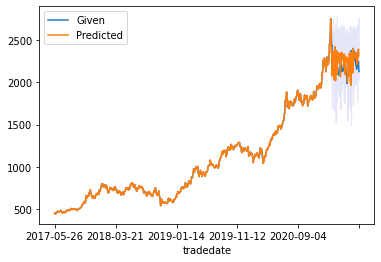

In [26]:
plot_predicted_observed_at_quantile(ts, observed, prediction, quantile='0.5', upper='0.9', lower='0.1')

在终端节点不再使用后一定将其删除，否则会一直产生费用：

In [27]:
predictor.delete_endpoint()